In [1]:
import os

import analysis_plotting_helper_functions_c3v3 as helper
import utils_new
import analysis_utils as utils
import utils_c4

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", 
          "#beb9db", "#fdcce5", "#8bd3c7"]
continuous_colors = ["#54bebe", "#76c8c8", "#98d1d1", "#badbdb", "#dedad2", 
                     "#e4bcad", "#df979e", "#d7658b", "#c80064"]
custom_palette = {'l': colors[1], 's': colors[0]}

In [3]:
cohort = 'cohort_4'
to_analyze = 'full_clean'
data_dir = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
data_folder = os.path.join(data_dir, cohort, to_analyze)
figure_folder = os.path.join(data_dir, cohort, 'figures')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_4/full_clean
/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_4/figures


# Session based plotting

### load session log

In [4]:
training_session_log = utils_c4.load_data(os.path.join(data_folder, 'sessions_training.csv'))

make mouse list

In [5]:
mouse_list = utils.generate_mouse_list(training_session_log)
print(mouse_list)

['RZ026', 'RZ027', 'RZ028', 'RZ029', 'RZ030', 'RZ031', 'RZ032', 'RZ033']


### Plotting functions
should be moved to helper

In [6]:
def plot_each_mouse_per_line(data_df, column_name, plot_name, title, x_label, y_label, 
                             figure_folder=figure_folder, mouse_list=mouse_list):
    fig = plt.figure()
    for i, mouse in enumerate(mouse_list):
        session_mouse = data_df.loc[data_df.mouse == mouse]
        plt.plot(session_mouse.session, session_mouse[column_name], color=colors[i], label=mouse)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

In [19]:
def plot_overdays_colored_by_group(data_df, column_name, plot_name, title, x_label, y_label, 
                                   figure_folder=figure_folder, mouse_list=mouse_list, color_palette=custom_palette):
    fig = plt.figure()
    sns.lineplot(x="session",
                 y=column_name,
                 hue="exp",
                 data=data_df,
                 palette=color_palette)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(1,4)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

# Plot type of trials per session

### generate trial type df for plotting
Calculate proportions of trials types and generate trial type df

In [8]:
training_session_log

index  mouse        date      time exp training   rig  \
0       74  RZ026  2023-10-31  11-39-46   s  regular  rig2   
1      145  RZ028  2023-10-31  12-22-14   l  regular  rig2   
2      147  RZ029  2023-10-31  12-25-13   l  regular  rig3   
3      247  RZ030  2023-10-31  13-12-44   s  regular  rig2   
4      198  RZ031  2023-10-31  13-14-02   s  regular  rig3   
..     ...    ...         ...       ...  ..      ...   ...   
227     81  RZ029  2023-12-07  11-15-38   l  regular  rig2   
228    200  RZ032  2023-12-07  14-23-24   l  regular  rig3   
229    211  RZ033  2023-12-07  14-24-21   l  regular  rig2   
230    189  RZ030  2023-12-07  15-12-34   s  regular  rig3   
231     69  RZ031  2023-12-07  15-13-42   s  regular  rig2   

                           dir  num_blocks  num_trials  rewards  session_time  \
0    2023-10-31_11-39-46_RZ026         1.0       487.0    187.7       2403.29   
1    2023-10-31_12-22-14_RZ028         1.0       353.0     89.9       2405.82   
2    2023-10-31_12-25-13_RZ029         1.0       354.0     73.7       2402.37   
3    2023-10-31_13-12-44_RZ030         1.0       438.0    533.1       2405.46   
4    2023-10-31_13-14-02_RZ031         1.0       468.0    259.5       2405.59   
..                         ...         ...         ...      ...           ...   
227  2023-12-07_11-15-38_RZ029         1.0       298.0    571.7       2404.07   
228  2023-12-07_14-23-24_RZ032         1.0       306.0    432.2       2401.58   
229  2023-12-07_14-24-21_RZ033         1.0       304.0    493.5       2404.83   
230  2023-12-07_15-12-34_RZ030         1.0       367.0    861.4       2404.54   
231  2023-12-07_15-13-42_RZ031         1.0       470.0    174.5       2400.08   

     proper_end  correct_exp  session  
0          True         True        0  
1          True         True        0  
2          True         True        0  
3          True         True        0  
4          True         True        0  
..          ...          ...      ...  
227        True         True       28  
228        True         True       28  
229        True         True       28  
230        True         True       28  
231        True         True       28  

[232 rows x 15 columns]

In [9]:
def generate_trial_type_df(training_session_log):
    for _, session_info in training_session_log.iterrows():
        all_trials = utils_c4.load_data(utils_c4.generate_trials_analyzed_path(data_folder, session_info))
        session_performance = helper.get_session_performance(all_trials)
        training_session_log.loc[training_session_log.dir == session_info['dir'], 
                                    ['miss_trials', 'good_trials']] = session_performance
    trial_type_df = training_session_log[['mouse', 'exp', 'session', 'num_trials', 
                                            'miss_trials', 'good_trials']].copy()
    trial_type_df['p_miss'] = trial_type_df.miss_trials/trial_type_df.num_trials
    trial_type_df['p_good'] = trial_type_df.good_trials/trial_type_df.num_trials
    trial_type_df['p_accident'] = 1 - trial_type_df.p_good - trial_type_df.p_miss 
    return trial_type_df

In [10]:
trial_type_df = generate_trial_type_df(training_session_log)

In [11]:
trial_type_df

mouse exp  session  num_trials  miss_trials  good_trials    p_miss  \
0    RZ026   s        0       487.0          0.0        238.0  0.000000   
1    RZ028   l        0       353.0          0.0          9.0  0.000000   
2    RZ029   l        0       354.0          0.0          4.0  0.000000   
3    RZ030   s        0       438.0          0.0        223.0  0.000000   
4    RZ031   s        0       468.0          0.0        248.0  0.000000   
..     ...  ..      ...         ...          ...          ...       ...   
227  RZ029   l       28       298.0          1.0        169.0  0.003356   
228  RZ032   l       28       306.0          0.0        168.0  0.000000   
229  RZ033   l       28       304.0          1.0         90.0  0.003289   
230  RZ030   s       28       367.0          9.0        266.0  0.024523   
231  RZ031   s       28       470.0          0.0        366.0  0.000000   

       p_good  p_accident  
0    0.488706    0.511294  
1    0.025496    0.974504  
2    0.011299    0.988701  
3    0.509132    0.490868  
4    0.529915    0.470085  
..        ...         ...  
227  0.567114    0.429530  
228  0.549020    0.450980  
229  0.296053    0.700658  
230  0.724796    0.250681  
231  0.778723    0.221277  

[232 rows x 9 columns]

### trial type combined plot

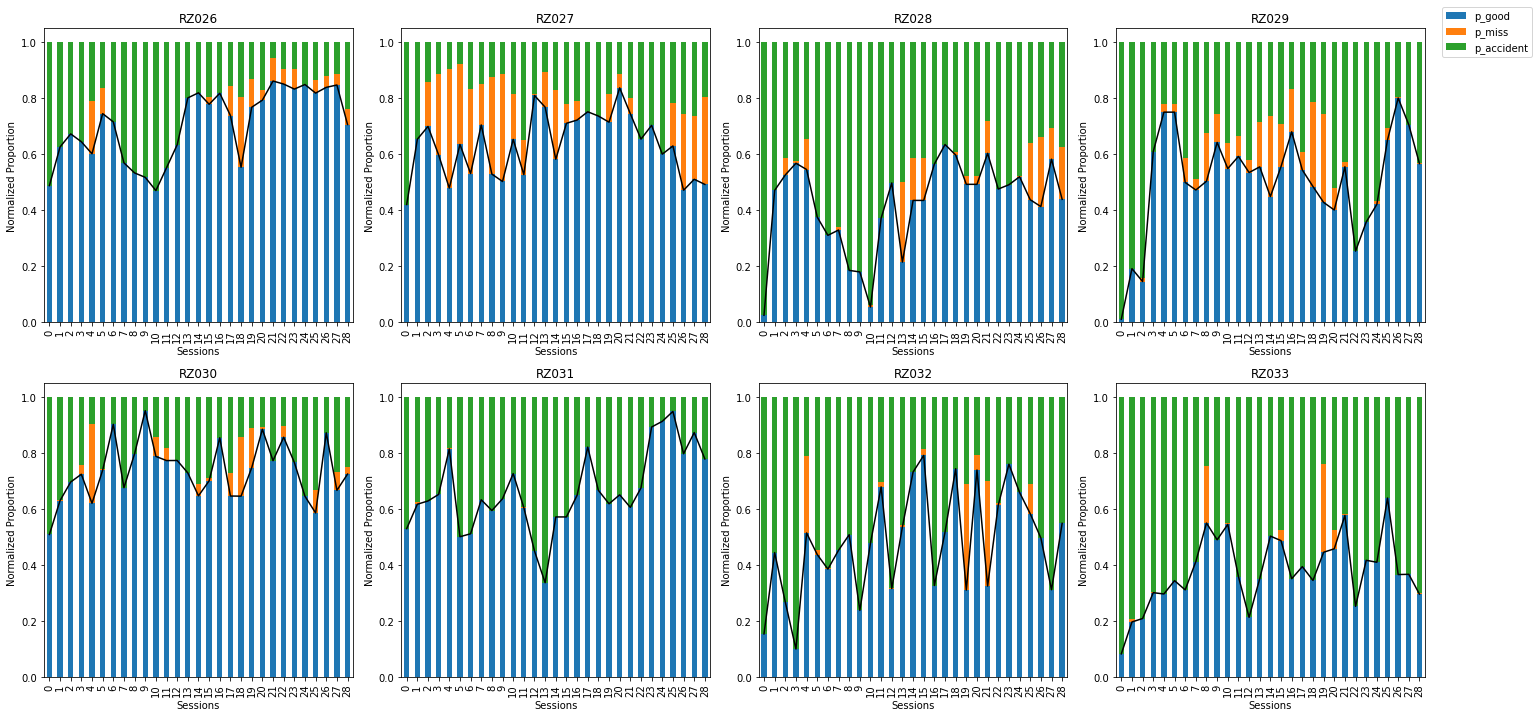

In [12]:
# ploting the proportion of good trials, miss trials, and enl trials per session
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = trial_type_df.loc[trial_type_df.mouse == mouse]
    to_plot = session_mouse.loc[:, ['session', 'p_good', 'p_miss', 'p_accident']]
    ax = axs.flat[i]
    to_plot.plot.bar(x='session', stacked=True, ax=ax, legend=None)
    ax.set_title(mouse)
    ax.set_xlabel('Sessions')
    ax.set_ylabel('Normalized Proportion')
    ax.plot(to_plot.session, to_plot.p_good, color='k', linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.07, 1))

plt.tight_layout()
plt.savefig(f'{figure_folder}/engagement_plots.png', bbox_inches='tight')
plt.show()

### percentage good trials

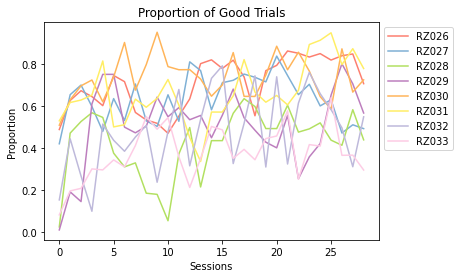

In [13]:
# plot the proportion of good trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_good', 
                         plot_name="%_good_trials", 
                         title='Proportion of Good Trials',
                         x_label='Sessions', 
                         y_label='Proportion')

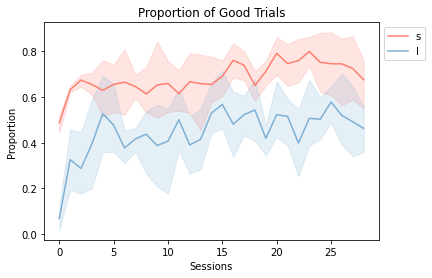

In [14]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_good", 
                               plot_name='%_good_trials_by_group', 
                               title='Proportion of Good Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

### Percent missed trials

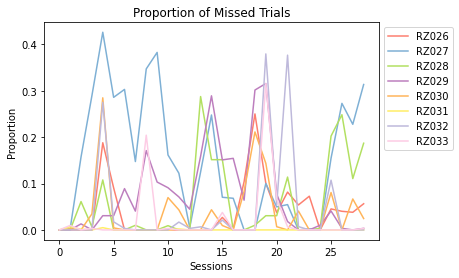

In [15]:
# plot the proportion of miss trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_miss', 
                         plot_name="%_miss_trials",
                         title='Proportion of Missed Trials', 
                         x_label='Sessions', 
                         y_label='Proportion')

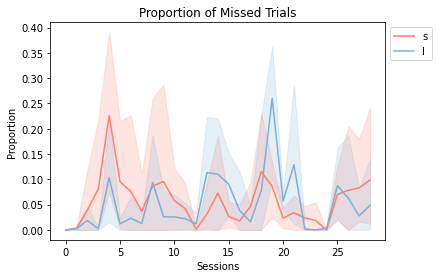

In [16]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_miss", 
                               plot_name='%_miss_trials_by_group', 
                               title='Proportion of Missed Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

### Percent accident trials

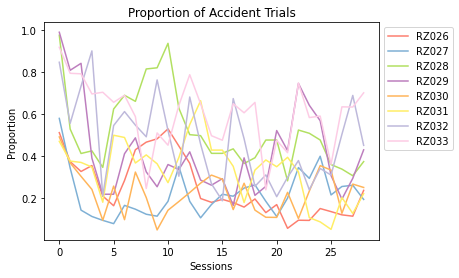

In [17]:
# plot the proportion of accident trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_accident', 
                         plot_name="%_accident_trials", 
                         title='Proportion of Accident Trials',
                         x_label='Sessions', 
                         y_label='Proportion')

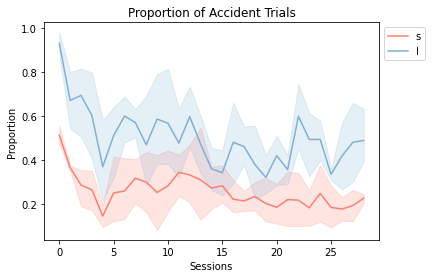

In [18]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_accident", 
                               plot_name='%_accident_trials_by_group', 
                               title='Proportion of Accident Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

# Plot rewards per session

### add info to training session log for plotting

In [19]:
training_session_log['reward_rate'] = training_session_log.rewards/training_session_log.session_time

In [20]:
training_session_log['reward_per_trial'] = training_session_log.rewards/training_session_log.num_trials

### plot reward size

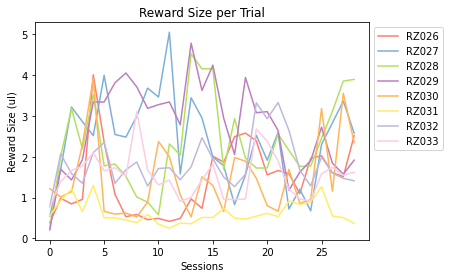

In [21]:
# plot the reward rize
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='reward_per_trial', 
                         plot_name="reward_size",
                         title='Reward Size per Trial', 
                         x_label='Sessions', 
                         y_label='Reward Size (ul)')

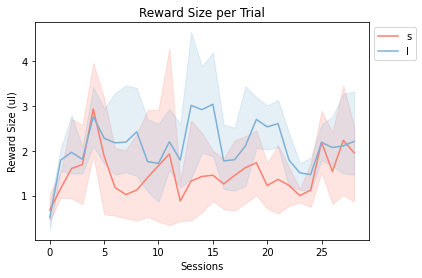

In [22]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="reward_per_trial", 
                               plot_name='reward_size_by_group', 
                               title='Reward Size per Trial', 
                               x_label='Sessions', 
                               y_label='Reward Size (ul)')

### Plot reward rate

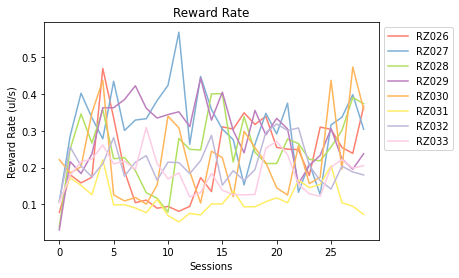

In [23]:
# plot the reward rate
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='reward_rate', 
                         plot_name="reward_rate",
                         title='Reward Rate', 
                         x_label='Sessions', 
                         y_label='Reward Rate (ul/s)')

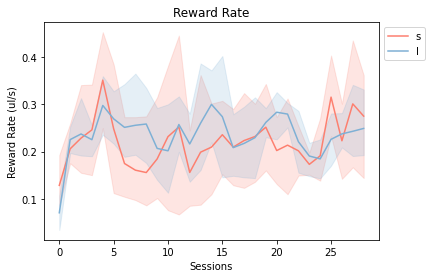

In [24]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="reward_rate", 
                               plot_name='reward_rate_by_group', 
                               title='Reward Rate', 
                               x_label='Sessions', 
                               y_label='Reward Rate (ul/s)')

### Plot session length

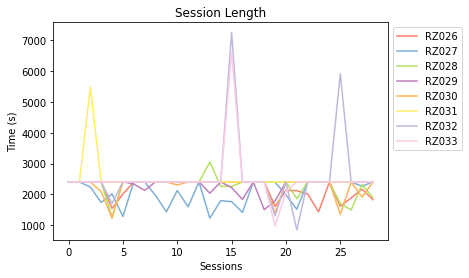

In [25]:
# plot the session length
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='session_time', 
                         plot_name="session_length", 
                         title='Session Length',
                         x_label='Sessions', 
                         y_label='Time (s)')

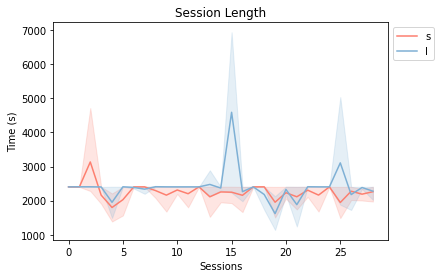

In [26]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="session_time", 
                               plot_name='session_length_by_group', 
                               title='Session Length', 
                               x_label='Sessions', 
                               y_label='Time (s)')

### plot num trials completed

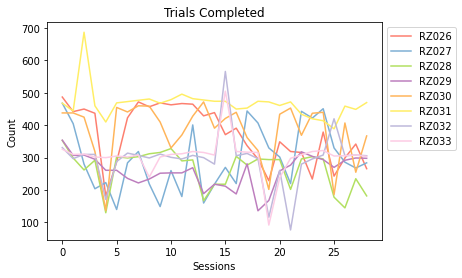

In [27]:
# plot the number of trials completed
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='num_trials', 
                         plot_name="num_trials", 
                         title='Trials Completed',
                         x_label='Sessions', 
                         y_label='Count')

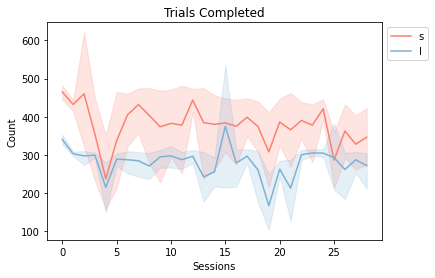

In [28]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="num_trials", 
                               plot_name='num_trials_by_group', 
                               title='Trials Completed', 
                               x_label='Sessions', 
                               y_label='Count')

# Plot time wait behavior

### generate wait df for plotting

In [12]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'session', 'dir', 'exp']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils_c4.load_data(utils_c4.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [13]:
wait_df = generate_wait_df(training_session_log)

In [14]:
wait_df

mouse  session                        dir exp   tw_mean  tw_median  \
0    RZ026        0  2023-10-31_11-39-46_RZ026   s  0.936871   0.628160   
1    RZ028        0  2023-10-31_12-22-14_RZ028   l  0.842040   0.542099   
2    RZ029        0  2023-10-31_12-25-13_RZ029   l  0.810126   0.616798   
3    RZ030        0  2023-10-31_13-12-44_RZ030   s  1.485620   0.898638   
4    RZ031        0  2023-10-31_13-14-02_RZ031   s  1.125707   0.861836   
..     ...      ...                        ...  ..       ...        ...   
227  RZ029       28  2023-12-07_11-15-38_RZ029   l  2.059467   1.812612   
228  RZ032       28  2023-12-07_14-23-24_RZ032   l  1.823051   1.619106   
229  RZ033       28  2023-12-07_14-24-21_RZ033   l  1.895658   1.447088   
230  RZ030       28  2023-12-07_15-12-34_RZ030   s  2.441451   2.130039   
231  RZ031       28  2023-12-07_15-13-42_RZ031   s  1.102930   1.001559   

     tw_stdev  tw_mean_g  tw_median_g  tw_stdev_g  
0    0.969301   1.036522     0.706968    0.990000  
1    0.850140   0.472210     0.301928    0.421330  
2    0.779605   2.272026     1.751673    2.134615  
3    1.577607   1.725770     1.364053    1.460078  
4    1.083514   1.258185     1.060133    1.031110  
..        ...        ...          ...         ...  
227  1.591173   1.773324     1.524271    1.262623  
228  1.362126   1.573470     1.375733    1.083051  
229  1.682440   1.277867     0.836001    1.476965  
230  1.876304   2.666525     2.243439    1.646671  
231  0.859784   1.201621     1.124518    0.732843  

[232 rows x 10 columns]

### plot time watied

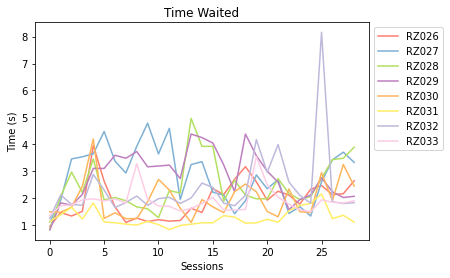

In [15]:
# plot the time waited over days. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean', 
                         plot_name="tw_mean", 
                         title='Time Waited',
                         x_label='Sessions', 
                         y_label='Time (s)')

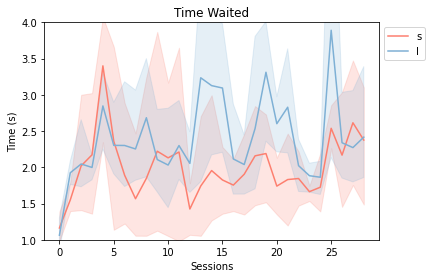

In [20]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean", 
                               plot_name='tw_mean_by_group', 
                               title='Time Waited', 
                               x_label='Sessions', 
                               y_label='Time (s)')

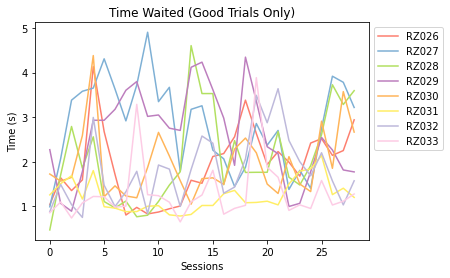

In [34]:
# plot the time waited over days good trials only. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean_g', 
                         plot_name="tw_mean_g", 
                         title='Time Waited (Good Trials Only)',
                         x_label='Sessions', 
                         y_label='Time (s)')

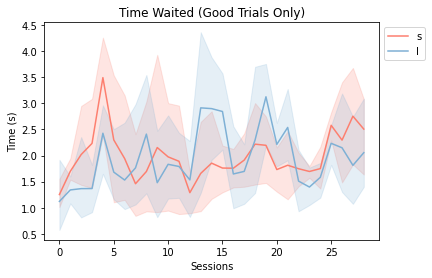

In [35]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean_g", 
                               plot_name='tw_mean_g_by_group', 
                               title='Time Waited (Good Trials Only)', 
                               x_label='Sessions', 
                               y_label='Time (s)')

## some stats

### check if short and long tw are significantly different?
yes for both all trials and good trials only
where should this session go??

In [36]:
short = wait_df[wait_df['exp']=='s']
long = wait_df[wait_df['exp']=='l']

#perform independent two sample t-test
ttest_ind(short['tw_mean'], long['tw_mean'])

Ttest_indResult(statistic=-3.155609971921023, pvalue=0.0018155659904184956)

In [37]:
print(short.tw_mean.mean())
print(long.tw_mean.mean())

1.9998380713058561
2.3963036175400516


### check if boys and girls are significantly different
nope they are not different

In [68]:
boys =  ['RZ026', 'RZ027', 'RZ028', 'RZ029']
girls = ['RZ030', 'RZ031', 'RZ032', 'RZ033']

In [71]:
boy = wait_df[wait_df['mouse'].isin(boys)]
girl = wait_df[wait_df['mouse'].isin(girls)]

ttest_ind(boy['tw_mean'], girl['tw_mean'])

Ttest_indResult(statistic=5.453395403990898, pvalue=1.2723072652825466e-07)

In [70]:
print(boy.tw_mean.mean())
print(girl.tw_mean.mean())

2.527344973288654
1.8687967155572538


In [72]:
boy_short = boy[boy['exp']=='s']
boy_long = boy[boy['exp']=='l']
print(boy_short.tw_mean.mean())
print(boy_long.tw_mean.mean())
ttest_ind(boy_short['tw_mean'], boy_long['tw_mean'])

2.3962793857595774
2.6584105608177295


Ttest_indResult(statistic=-1.4738128932950312, pvalue=0.14328800254317775)

In [73]:
girl_short = girl[girl['exp']=='s']
girl_long = girl[girl['exp']=='l']
print(girl_short.tw_mean.mean())
print(girl_long.tw_mean.mean())
ttest_ind(girl_short['tw_mean'], girl_long['tw_mean'])

1.603396756852135
2.134196674262373


Ttest_indResult(statistic=-3.416716564518609, pvalue=0.0008793021510457882)

## plots to be figured out

In [ ]:
# time wait per mouse with mean and median
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 3 columns

for i, mouse in enumerate(mouse_list):
    session_mouse = wait_df.loc[wait_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.session, session_mouse.tw_mean, session_mouse.tw_stdev, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.session, session_mouse.tw_median, color=colors[1], 
               label='median')
    ax.set_title(mouse)
    ax.set_xlabel('Sessions')
    ax.set_ylabel('Time Waited (s)')
    ax.set_ylim(0,7.5)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(f'{figure_folder}/tw_plots.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# time wait good per mouse, with mean and median
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = wait_df.loc[wait_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.session, session_mouse.tw_mean_g, session_mouse.tw_stdev_g, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.session, session_mouse.tw_median_g, color=colors[1], 
               label='median')
    ax.set_title(mouse)
    ax.set_xlabel('Session')
    ax.set_ylabel('Time Waited (s)')
    ax.set_ylim(0,7.5)

# Extract the legend from the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()

# Set the figure legend outside the loop
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/tw_good_plots.png', bbox_inches='tight', dpi=300)

# Show the plot (optional)
plt.show()

In [42]:
def calculate_subplot_row_col(session_mouse, plots_per_row):
    days_trained = len(session_mouse)
    num_rows = (days_trained - 1) // plots_per_row + 1
    num_cols = min(days_trained, plots_per_row)
    return num_rows, num_cols

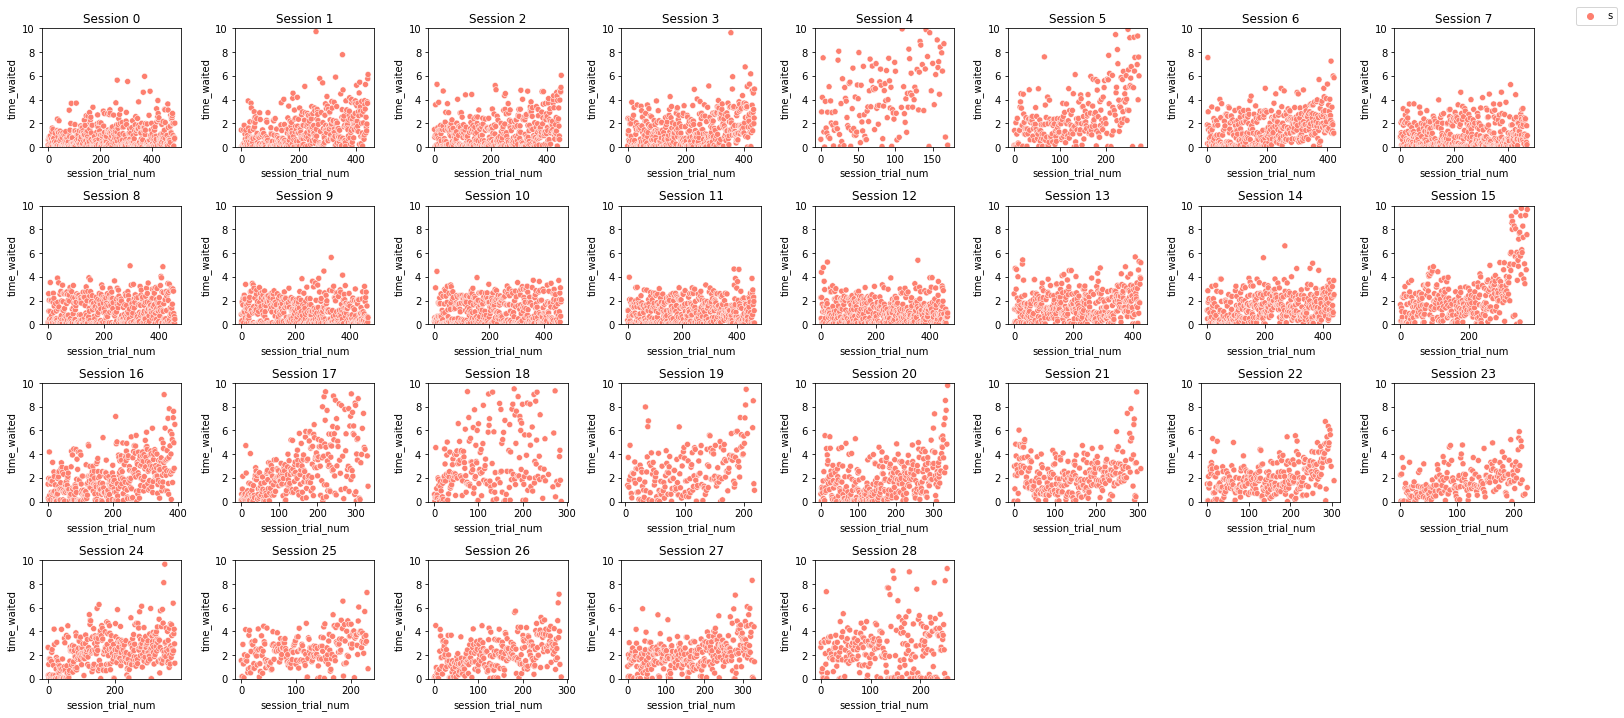

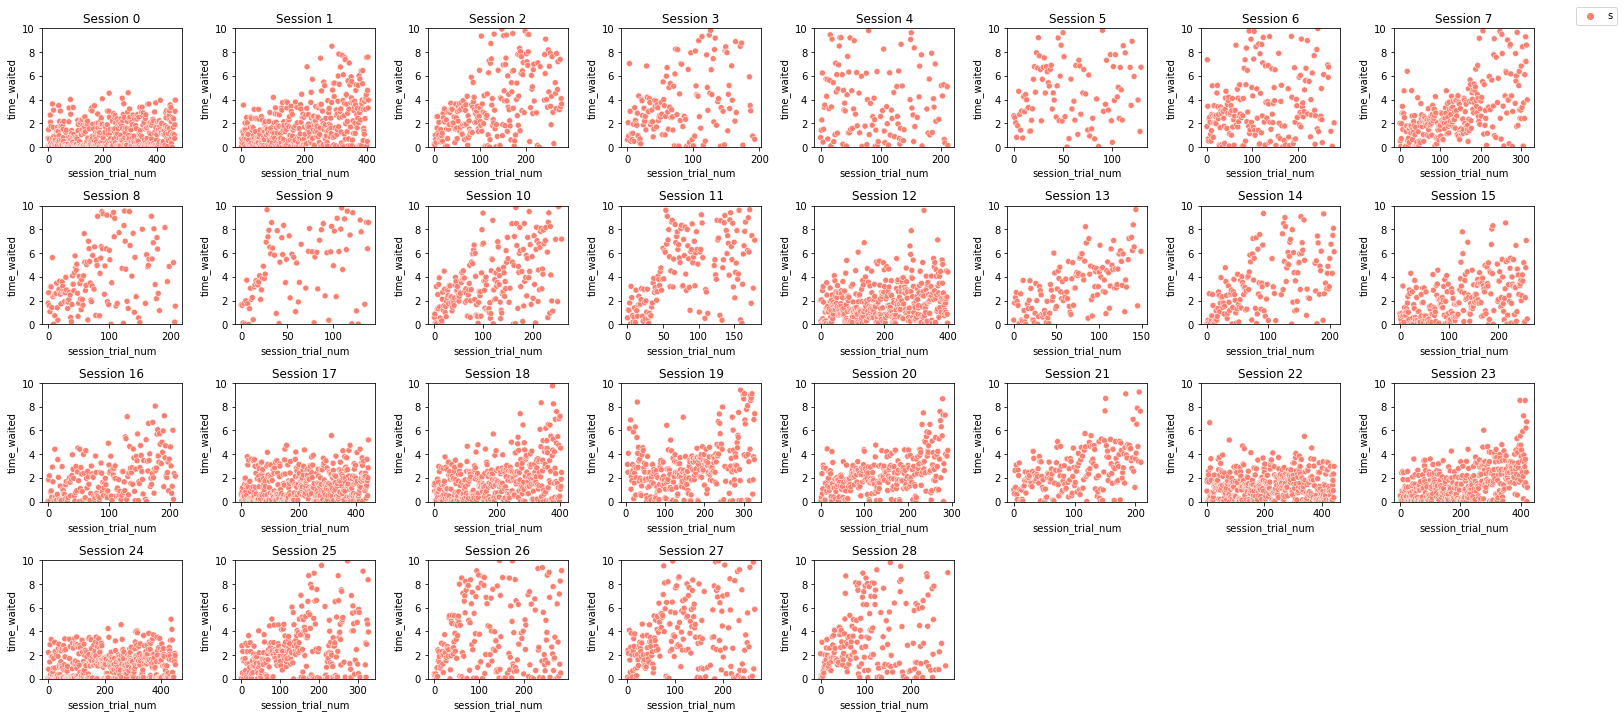

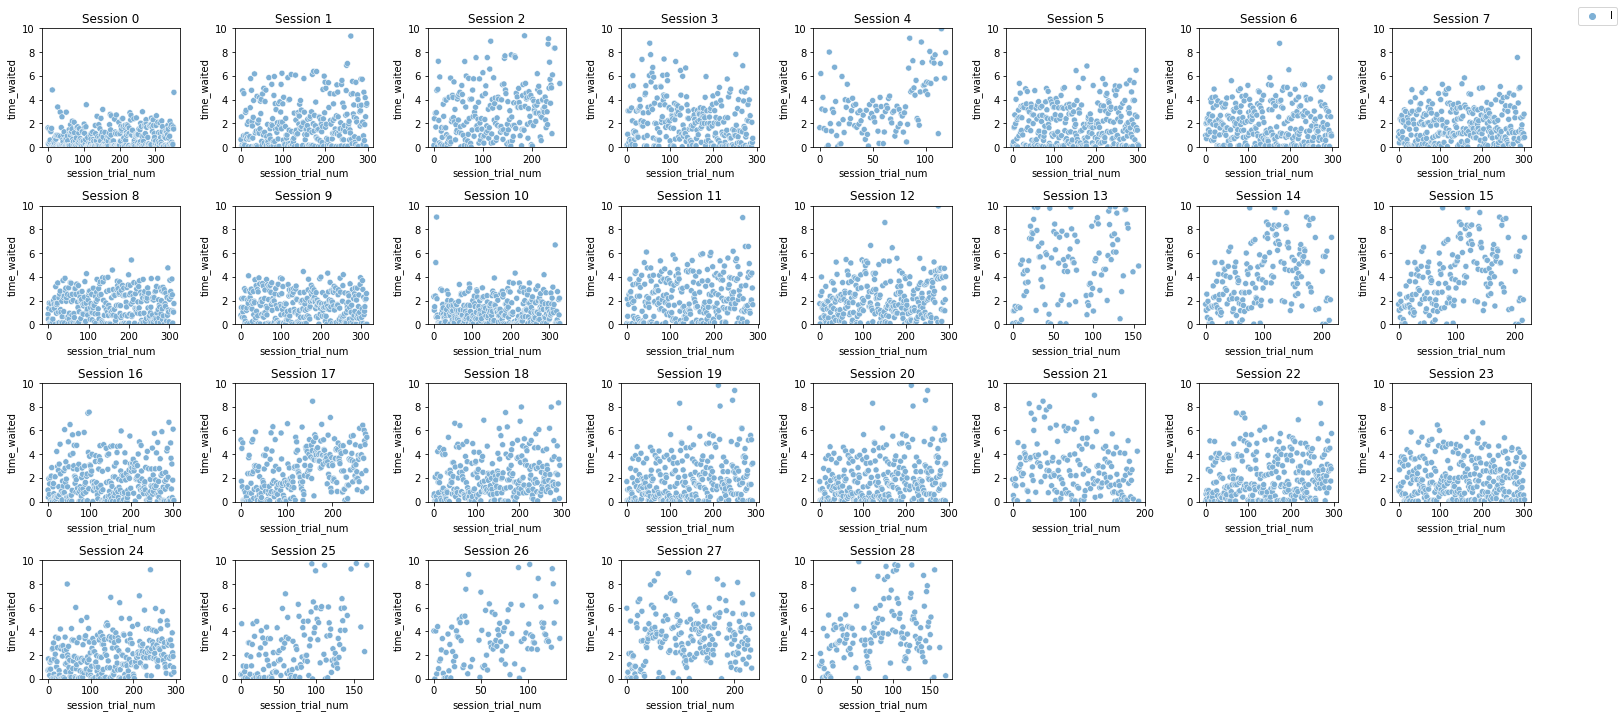

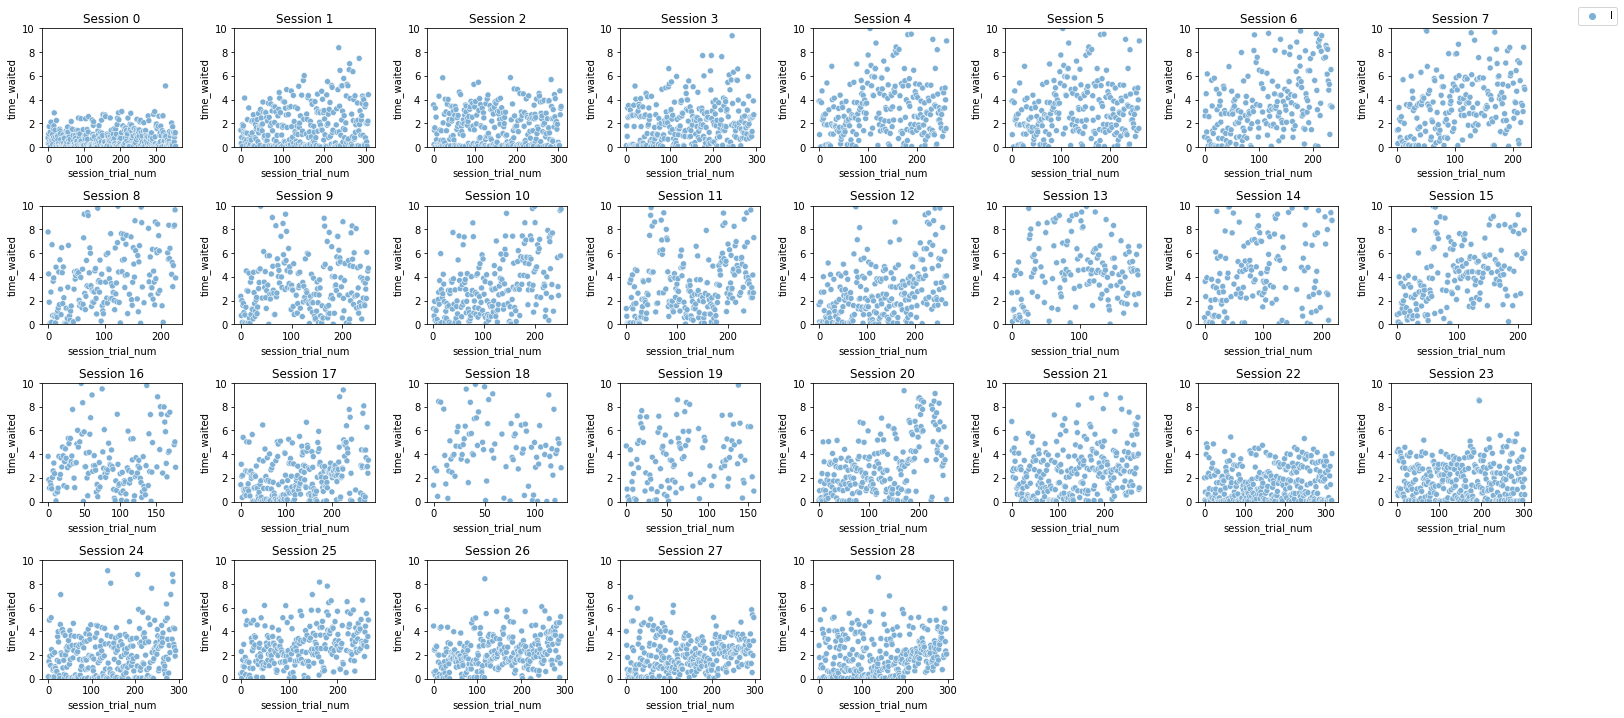

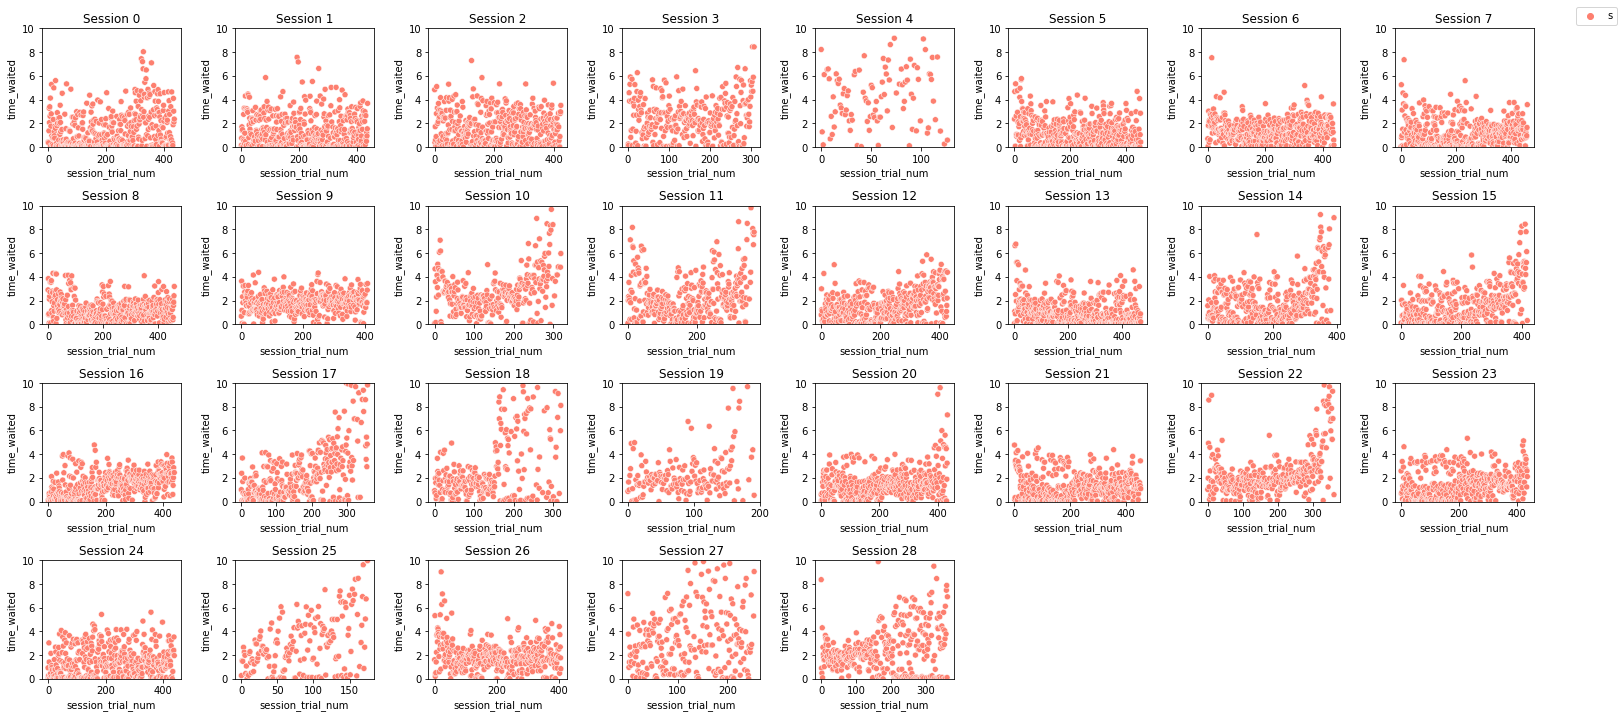

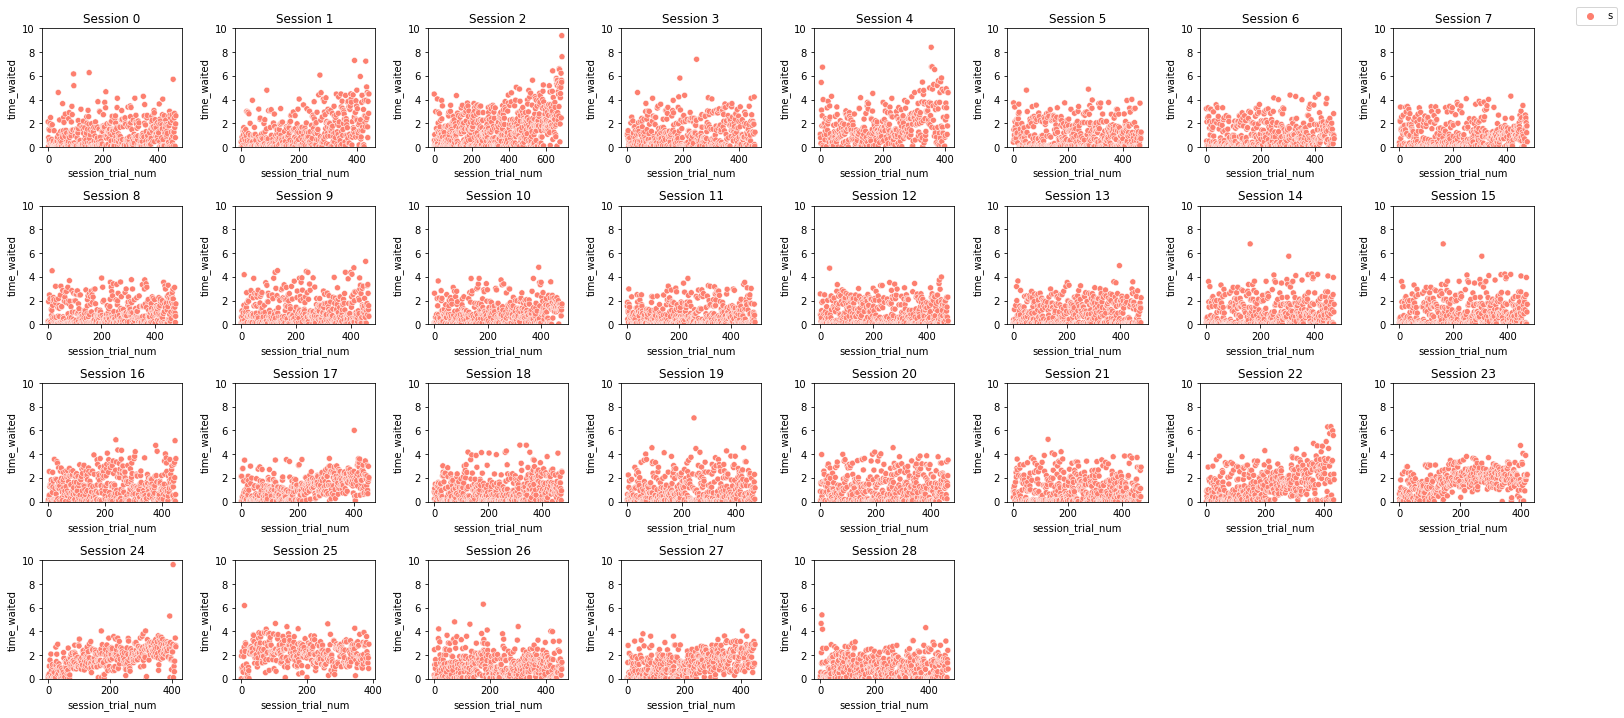

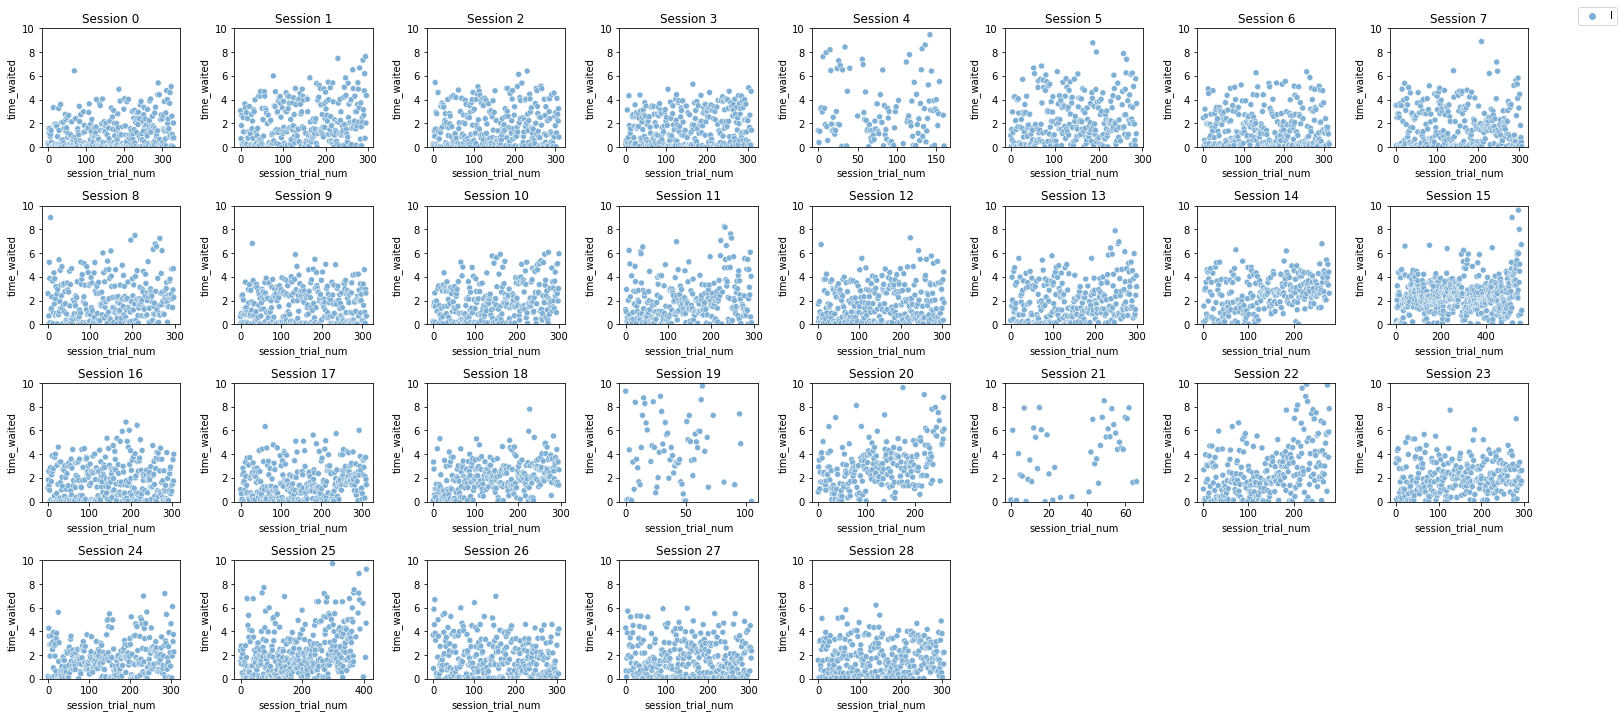

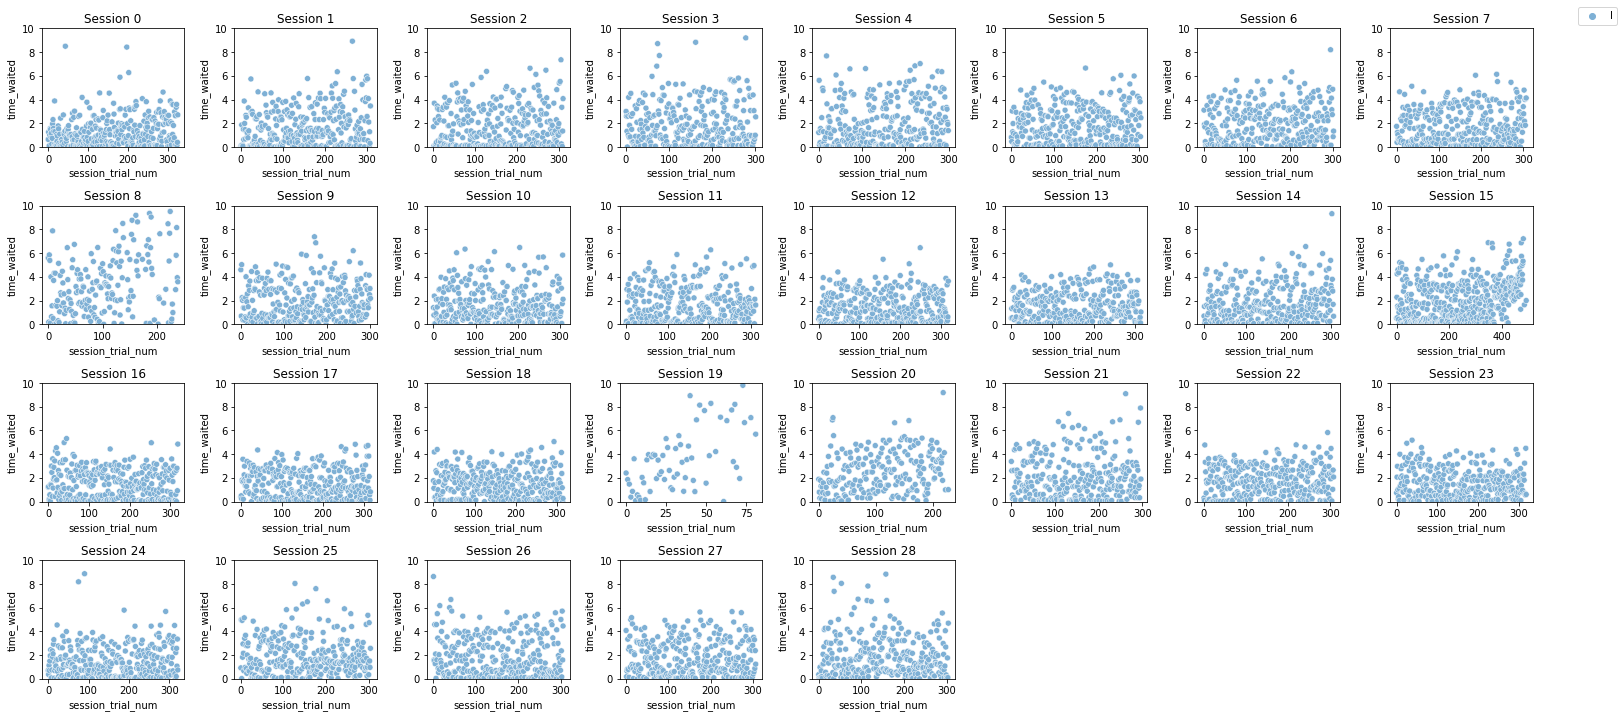

In [43]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    num_rows, num_cols = calculate_subplot_row_col(session_mouse, 8)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(21.5, 2.5 * num_rows))

    for i, (_, session_info) in enumerate(session_mouse.iterrows()):
        all_trials = utils_c4.load_data(utils_c4.generate_trials_analyzed_path(data_folder, session_info))
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        sns.scatterplot(x="session_trial_num",
                        y="time_waited",
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Session {i}')
        ax.set_ylim([0, 10])
        ax.legend().remove()

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)

In [ ]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, sess) in enumerate(zip(session_mouse.dir, session_mouse.session_num)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        sns.scatterplot(x="session_trial_num",
                        y="time_waited",
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Session {sess}')
        ax.set_ylim([0, 10])

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)

In [ ]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, sess) in enumerate(zip(session_mouse.dir, session_mouse.session_num)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        custom_palette = {'l': colors[1], 's': colors[0]}
        
        sns.scatterplot(x="bg_length",
                        y="time_waited",
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Session {sess}')
        ax.set_ylim([0, 10])

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)

# Stitched all sessions all mice per day

In [44]:
cohort = 'cohort_4'
to_analyze = 'padded_stitched'
data_dir = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
data_folder = os.path.join(data_dir, cohort, to_analyze)
figure_folder = os.path.join(data_dir, cohort, 'padded_figures')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_4/padded_stitched
/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_4/padded_figures


In [45]:
stitched_log = utils.load_session_log(data_folder, 'sessions_training_stitched.csv')

In [46]:
stitched_log

date training  session  num_blocks  num_trials  rewards  \
0   2023-10-31  regular        0         8.0      3225.0   1911.6   
1   2023-11-01  regular        1         8.0      2942.0   4150.2   
2   2023-11-02  regular        2         9.0      3033.0   4887.6   
3   2023-11-03  regular        3         8.0      2619.0   4202.3   
4   2023-11-03  regular        4         8.0      1813.0   4676.3   
5   2023-11-04  regular        5         8.0      2508.0   4368.8   
6   2023-11-05  regular        6         8.0      2772.0   4073.6   
7   2023-11-06  regular        7         8.0      2868.0   3891.9   
8   2023-11-07  regular        8         8.0      2701.0   3843.5   
9   2023-11-08  regular        9         8.0      2677.0   3392.3   
10  2023-11-09  regular       10         8.0      2724.0   4021.6   
11  2023-11-10  regular       11         8.0      2664.0   4446.6   
12  2023-11-12  regular       12         8.0      2964.0   3578.1   
13  2023-11-13  regular       13         9.0      2511.0   3892.7   
14  2023-11-14  regular       14         8.0      2546.0   4631.5   
15  2023-11-15  regular       15        10.0      3037.0   5904.4   
16  2023-11-16  regular       16         8.0      2618.0   3577.2   
17  2023-11-17  regular       17         8.0      2784.0   4240.3   
18  2023-11-17  regular       18         8.0      2544.0   4122.2   
19  2023-11-29  regular       19         8.0      1903.0   3594.8   
20  2023-11-30  regular       20         8.0      2598.0   4399.4   
21  2023-11-30  regular       21         8.0      2318.0   3726.8   
22  2023-12-01  regular       22         8.0      2765.0   3971.8   
23  2023-12-02  regular       23         8.0      2735.0   3324.9   
24  2023-12-03  regular       24         8.0      2904.0   3611.7   
25  2023-12-04  regular       25         9.0      2321.0   4830.3   
26  2023-12-05  regular       26         8.0      2500.0   4027.3   
27  2023-12-06  regular       27         8.0      2464.0   4862.7   
28  2023-12-07  regular       28         8.0      2477.0   4645.8   

    session_time  proper_end  
0       62958.68        True  
1       92528.09        True  
2       93254.17        True  
3       48806.09        True  
4       44786.86        True  
5      426901.11        True  
6       54142.84        True  
7       51936.30        True  
8       67753.79        True  
9       49173.70        True  
10      50625.32        True  
11      49668.89        True  
12      52477.36        True  
13      46014.54        True  
14      48596.05        True  
15     447362.45        True  
16      84472.29        True  
17      52275.88        True  
18      50028.95        True  
19      42850.73        True  
20     364626.29        True  
21      43679.99        True  
22      69744.42        True  
23      48775.41        True  
24      50545.14        True  
25      52677.13        True  
26      59413.61        True  
27      49901.03        True  
28      84551.70        True

In [51]:
def generate_events_processed_stitched_path(data_folder, session_info):
    filename = f'events_processed_stitched_{session_info.date}_{session_info.session}.csv'
    return os.path.join(data_folder, f"{session_info.date}_{session_info.session}", filename)

In [52]:
def generate_trials_analyzed_stitched_path(data_folder, session_info):
    filename = f'trials_analyzed_stitched_{session_info.date}_{session_info.session}.csv'
    return os.path.join(data_folder, f"{session_info.date}_{session_info.session}", filename)

In [ ]:
def generate_stitched_all_mice_all_trials_analyzed_path(data_folder, session_info):
    return os.path.join(data_folder, session_info.date, 
                        f'stitched_all_mice_all_trials_analyzed_{session_info.date}.csv')

In [ ]:
def load_stitched_all_mice_all_trials_analyzed(data_folder, session_info):
    path = generate_stitched_all_mice_all_trials_analyzed_path(data_folder, session_info)
    all_trials_df = pd.read_csv(path, index_col=0)
    return all_trials_df

In [49]:
def generate_stitched_wait_df(training_session_log):
    wait_df = training_session_log[['date', 'days']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils.load_data(generate_trials_analyzed_stitched_path(data_folder, session_info))
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.date == session_info['date'], 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.date == session_info['date'], 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

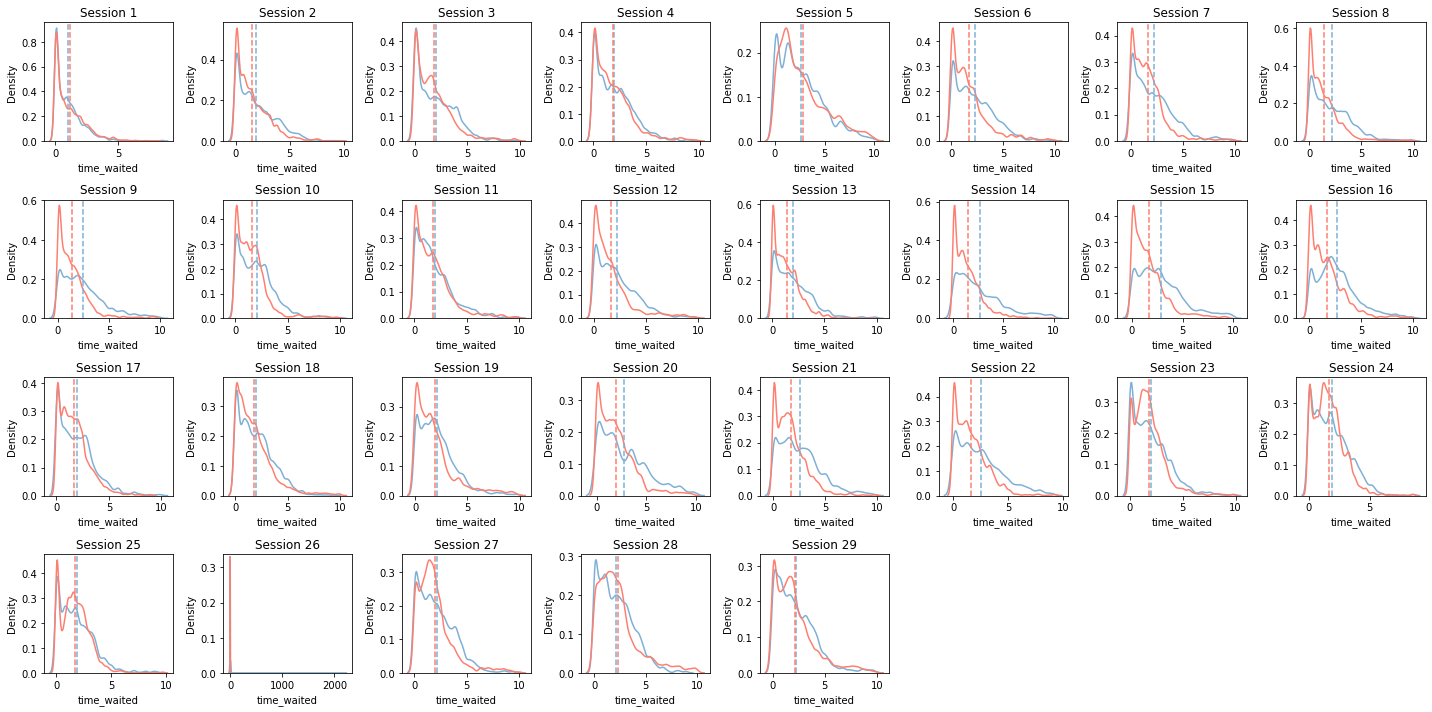

In [54]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 8 + 1
num_cols = min(days_trained, 8)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c4.load_data(generate_trials_analyzed_stitched_path(data_folder, session_info))
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.kdeplot(data=all_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="blk_type",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=all_trials.loc[all_trials.blk_type == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=all_trials.loc[all_trials.blk_type == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    ax.set_title(f'Session {i+1}')
    
# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/tw_kde.png', bbox_inches='tight', dpi=300)

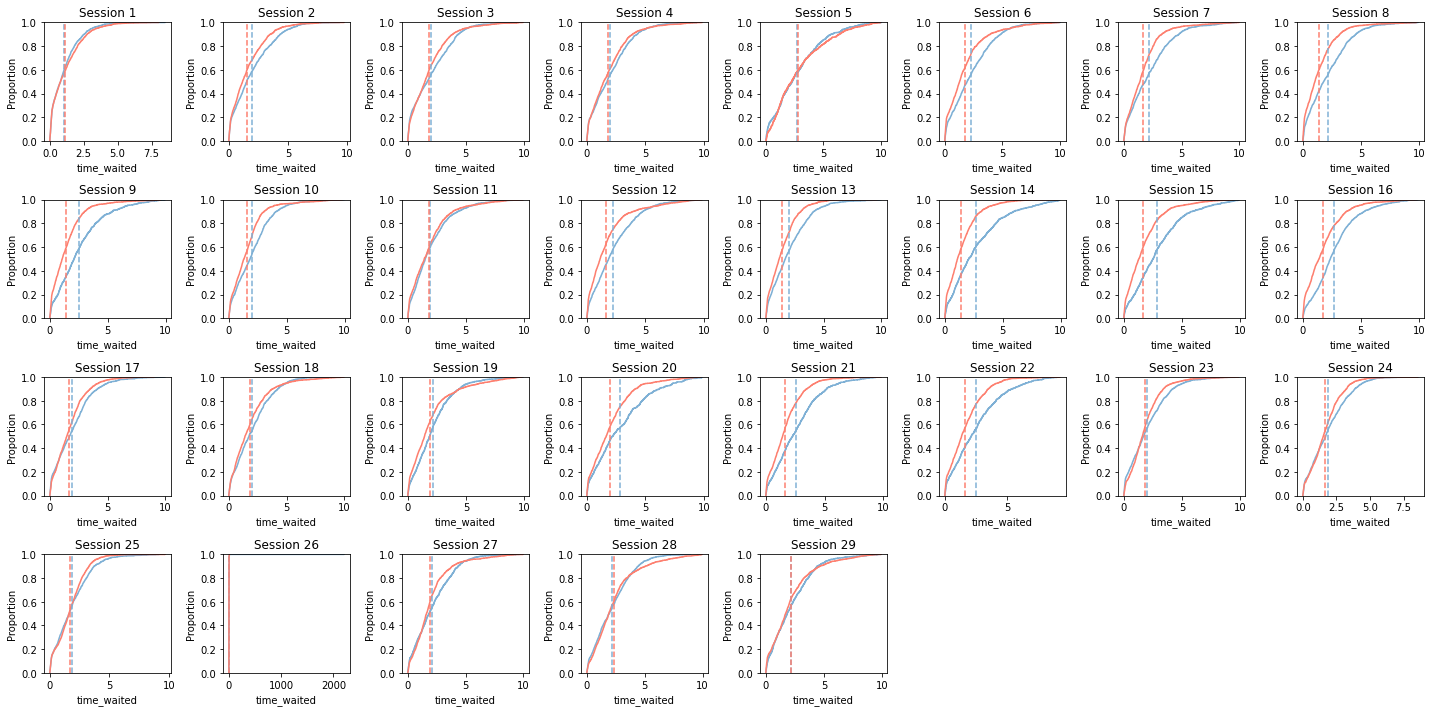

In [56]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 8 + 1
num_cols = min(days_trained, 8)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c4.load_data(generate_trials_analyzed_stitched_path(data_folder, session_info))
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.ecdfplot(data=all_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="blk_type",
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=all_trials.loc[all_trials.blk_type == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=all_trials.loc[all_trials.blk_type == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_title(f'Session {i+1}')
    
# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/tw_cdf.png', bbox_inches='tight', dpi=300)

In [58]:
def select_non_accident_trials(all_trials):
    non_accident_trials = all_trials[all_trials['time_waited'] > 0.5]
    return non_accident_trials

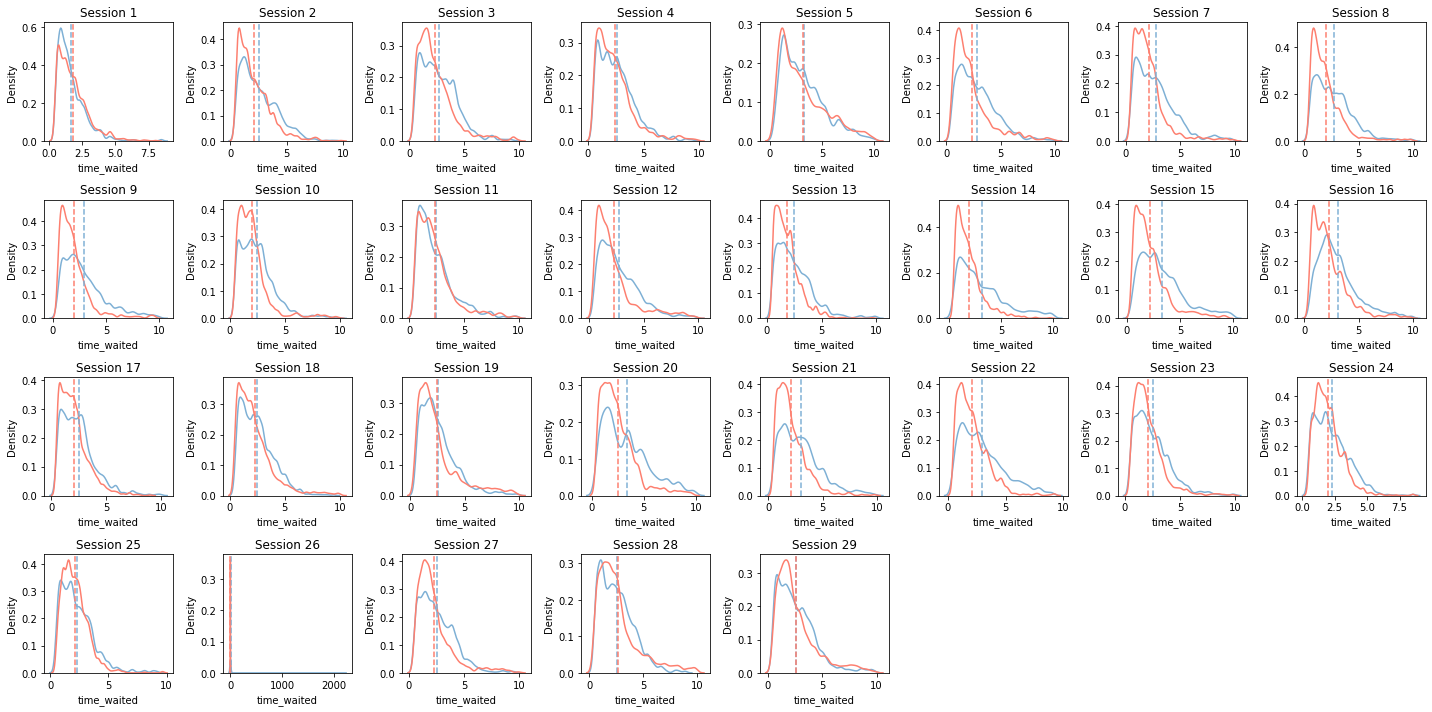

In [60]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 8 + 1
num_cols = min(days_trained, 8)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c4.load_data(generate_trials_analyzed_stitched_path(data_folder, session_info))
    non_accident_trials = select_non_accident_trials(all_trials)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.kdeplot(data=non_accident_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="blk_type",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.blk_type == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.blk_type == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_title(f'Session {i+1}')

# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/tw_g_kde.png', bbox_inches='tight', dpi=300)

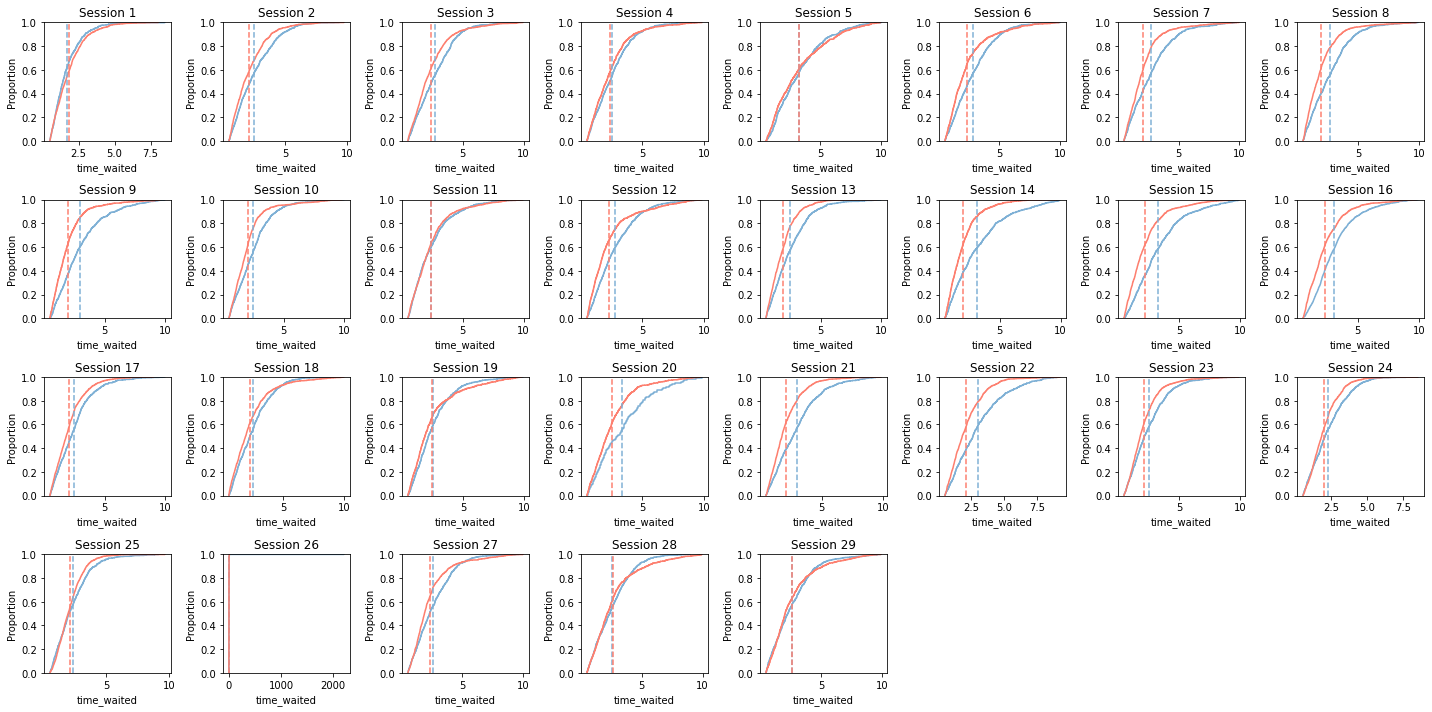

In [61]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 8 + 1
num_cols = min(days_trained, 8)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils_c4.load_data(generate_trials_analyzed_stitched_path(data_folder, session_info))
    non_accident_trials = select_non_accident_trials(all_trials)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.ecdfplot(data=non_accident_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="blk_type",
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.blk_type == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.blk_type == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_title(f'Session {i+1}')

# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/tw_g_cdf.png', bbox_inches='tight', dpi=300)

In [64]:
session_info = stitched_log[stitched_log['session']==25].iloc[0]

In [65]:
session_info

date            2023-12-04
training           regular
session                 25
num_blocks             9.0
num_trials          2321.0
rewards             4830.3
session_time      52677.13
proper_end            True
Name: 25, dtype: object

In [66]:
all_trials = utils_c4.load_data(generate_trials_analyzed_stitched_path(data_folder, session_info))

<AxesSubplot: xlabel='time_waited', ylabel='Proportion'>

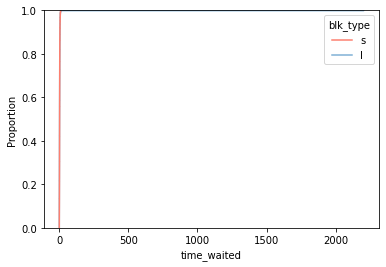

In [67]:
sns.ecdfplot(data=all_trials.reset_index(drop=True), 
                x="time_waited", 
                hue="blk_type",
                palette=custom_palette)

In [62]:
stitched_log

date training  session  num_blocks  num_trials  rewards  \
0   2023-10-31  regular        0         8.0      3225.0   1911.6   
1   2023-11-01  regular        1         8.0      2942.0   4150.2   
2   2023-11-02  regular        2         9.0      3033.0   4887.6   
3   2023-11-03  regular        3         8.0      2619.0   4202.3   
4   2023-11-03  regular        4         8.0      1813.0   4676.3   
5   2023-11-04  regular        5         8.0      2508.0   4368.8   
6   2023-11-05  regular        6         8.0      2772.0   4073.6   
7   2023-11-06  regular        7         8.0      2868.0   3891.9   
8   2023-11-07  regular        8         8.0      2701.0   3843.5   
9   2023-11-08  regular        9         8.0      2677.0   3392.3   
10  2023-11-09  regular       10         8.0      2724.0   4021.6   
11  2023-11-10  regular       11         8.0      2664.0   4446.6   
12  2023-11-12  regular       12         8.0      2964.0   3578.1   
13  2023-11-13  regular       13         9.0      2511.0   3892.7   
14  2023-11-14  regular       14         8.0      2546.0   4631.5   
15  2023-11-15  regular       15        10.0      3037.0   5904.4   
16  2023-11-16  regular       16         8.0      2618.0   3577.2   
17  2023-11-17  regular       17         8.0      2784.0   4240.3   
18  2023-11-17  regular       18         8.0      2544.0   4122.2   
19  2023-11-29  regular       19         8.0      1903.0   3594.8   
20  2023-11-30  regular       20         8.0      2598.0   4399.4   
21  2023-11-30  regular       21         8.0      2318.0   3726.8   
22  2023-12-01  regular       22         8.0      2765.0   3971.8   
23  2023-12-02  regular       23         8.0      2735.0   3324.9   
24  2023-12-03  regular       24         8.0      2904.0   3611.7   
25  2023-12-04  regular       25         9.0      2321.0   4830.3   
26  2023-12-05  regular       26         8.0      2500.0   4027.3   
27  2023-12-06  regular       27         8.0      2464.0   4862.7   
28  2023-12-07  regular       28         8.0      2477.0   4645.8   

    session_time  proper_end  
0       62958.68        True  
1       92528.09        True  
2       93254.17        True  
3       48806.09        True  
4       44786.86        True  
5      426901.11        True  
6       54142.84        True  
7       51936.30        True  
8       67753.79        True  
9       49173.70        True  
10      50625.32        True  
11      49668.89        True  
12      52477.36        True  
13      46014.54        True  
14      48596.05        True  
15     447362.45        True  
16      84472.29        True  
17      52275.88        True  
18      50028.95        True  
19      42850.73        True  
20     364626.29        True  
21      43679.99        True  
22      69744.42        True  
23      48775.41        True  
24      50545.14        True  
25      52677.13        True  
26      59413.61        True  
27      49901.03        True  
28      84551.70        True

### ignore the rest

In [ ]:
# cohort = 'cohort_2'
to_analyze = 'full_clean_analyzed'
data_dir = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
# figure_folder = os.path.join(data_dir, cohort, 'figures')
# data_folder = os.path.join(data_dir, cohort, to_analyze)
# print(data_folder)
# print(figure_folder)

In [ ]:
v1_data_folder = os.path.join(data_dir, 'cohort_1', 'full_clean')
v2_data_folder = os.path.join(data_dir, 'cohort_2', 'full_clean_analyzed')
v3_data_folder = os.path.join(data_dir, 'cohort_2_v2', 'full_clean')

In [ ]:
v1_wait = utils.load_session_log(v1_data_folder, 'wait.csv')
v2_wait = utils.load_session_log(v2_data_folder, 'wait.csv')
v3_wait = utils.load_session_log(v3_data_folder, 'wait.csv')

In [ ]:
v1_l = v1_wait.tw_l_mean.mean()
v2_l = v2_wait.tw_l_mean.mean()
v3_l = v3_wait.tw_l_mean.mean()

v1_s = v1_wait.tw_s_mean.mean()
v2_s = v2_wait.tw_s_mean.mean()
v3_s = v3_wait.tw_s_mean.mean()

In [ ]:
wait_time_l = [v1_l, v2_l, v3_l]
wait_time_s = [v1_s, v2_s, v3_s]

In [ ]:
sum(wait_time_l)/3

In [ ]:
sum(wait_time_s)/3

In [ ]:
stitched_log